# How to run your analysis parallelly

Here we show how to transform your own analysis script into something that can be run parallelly in MDAnalysis.

**Last executed:** Aug 13, 2020 with MDAnalysis 2.0.0

**Last updated:** Augus 2020

**Minimum version of MDAnalysis:** 2.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests


In [2]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import multiprocessing
from multiprocessing import Pool
from multiprocessing import cpu_count
from functools import partial

import dask

## Radius of gyration

For detail description of this analysis, read ``Writing your own trajectory``

Here is a common form of single-frame method that we can normally see inside `AnalysisBase`. It may contain both some dynamic parts that changes along time either implicitly or explicitly (e.g. `AtomGroup`) and some static parts (e.g. a reference frame).

In [4]:
def radgyr_old(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

## Transform into parallel-compatible form

First, we need to modify the single-frame method to contain the `frame_index`. Then we explicitly point to the frame need to be analyzed:

`atomgroup.universe.trajectory[frame_index]`

In [13]:
def radgyr(frame_index, atomgroup, masses, total_mass=None):
    atomgroup.universe.trajectory[frame_index]
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

In [14]:
u = mda.Universe(PSF, DCD)
protein = u.select_atoms('protein')

## Create a pool of workers with multiprocess

The native parallel module in python is called `multiprocessing`, it contains some useful tools to build a pool of working cores, map the function into different workers, and gather and order the results from all the workers.

Below we use `Pool` from `multiprocessing` as a context manager, we can define how many cores (or workers) we want tu use. By `Pool(n_jobs)`. Then we can map our analysis method `radgyr` with the parameters needed with `partial`. Note we do not include `frame_index` inside partial, because `frame_index` is the variable that is iterated to create a list of jobs.

The serialized version is:
```python
result = []
for frame_index in range(u.trajectory.n_frames):
    result.append(radgyr(frame_index,
                         atomgroup=protein,
                         masses=protein.masses,
                         total_mass=np.sum(protein.masses))
```

In [7]:
n_jobs = cpu_count()
with Pool(n_jobs) as worker_pool:
    result = worker_pool.map(partial(radgyr, 
                                     atomgroup=protein,
                                     masses=protein.masses,
                                     total_mass=np.sum(protein.masses)),
                             range(u.trajectory.n_frames))

The `result` will be a list of arrays containing the result for each frame.
Finally the results can be plotted along time.

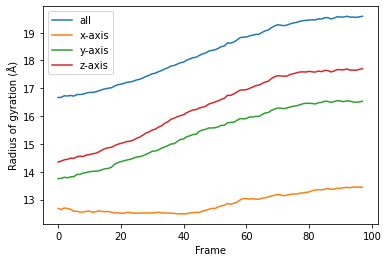

In [8]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

## Create a pool of workers with Dask

Dask is the parallel module that is used inside PMDA. It can be scaled from one single computer to a cluster of computers inside a HPC center.

Below is a simple example to use Dask to achieve the same task as `multiprocess` does.

The API of Dask is similiar to `multiprocess`. It also creates a pool of workers with the given resources.

In [9]:
from dask.distributed import Client

client = Client(n_workers=12)
client

Client Scheduler: tcp://127.0.0.1:33017 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 16.49 GB


First we have to create a list of jobs and transform them with `dask.delayed()` so they can be processed by Dask.

In [10]:
job_list = []
for frame_index in range(u.trajectory.n_frames):
    job_list.append(dask.delayed(radgyr(frame_index,
                                        atomgroup=protein,
                                        masses=protein.masses,
                                        total_mass=np.sum(protein.masses))))

Then we simply use `dask.compute()` to get a list of ordered results.

In [11]:
result = dask.compute(job_list)

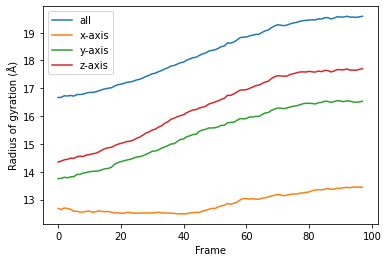

In [12]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

We can also use Dask dashboard to examine how jobs are distributed along all the workers. So each green bar below reprsents a single-frame `radgyr`.

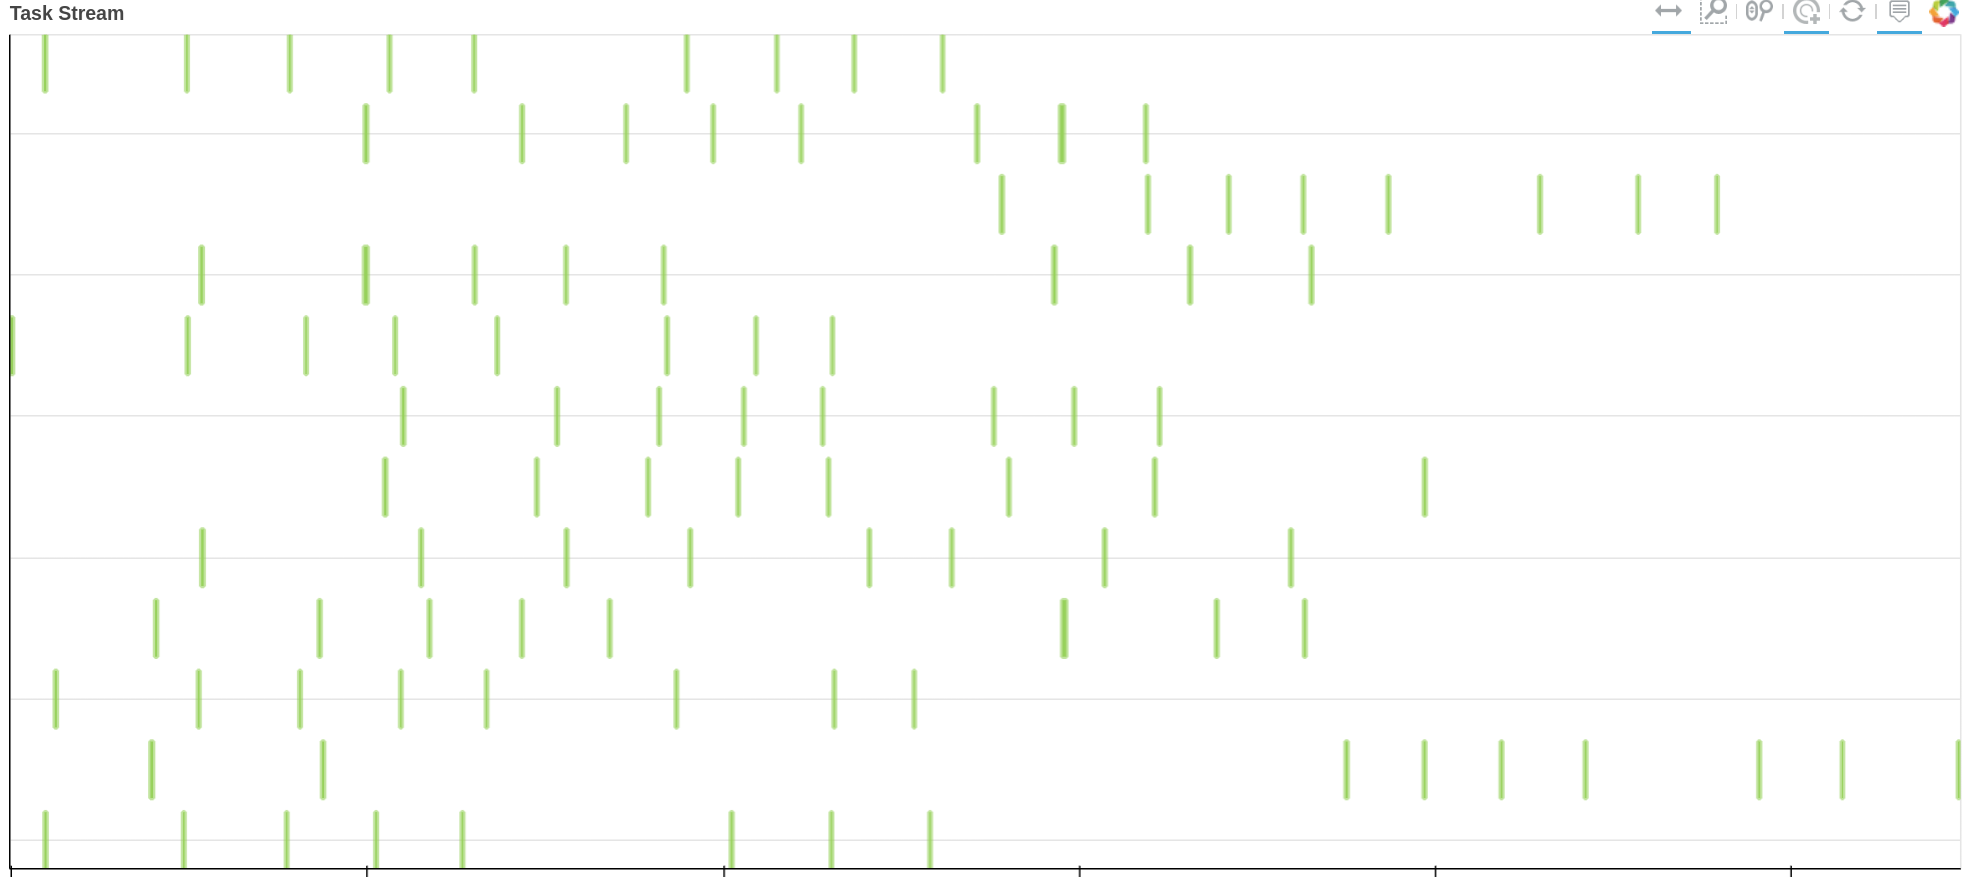

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Shujie Fan, Max Linke, Ioannis Paraskevakos, Richard J. Gowers, Michael Gecht, and Oliver Beckstein. 
<span class="bibtex-protected">PMDA</span> - <span class="bibtex-protected">Parallel</span> <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Analysis</span>. 
<em>Proceedings of the 18th Python in Science Conference</em>, pages 134–142, 2019.
URL: <a href="https://conference.scipy.org/proceedings/scipy2019/shujie_fan.html">https://conference.scipy.org/proceedings/scipy2019/shujie_fan.html</a>, <a href="https://doi.org/10.25080/Majora-7ddc1dd1-013">doi:10.25080/Majora-7ddc1dd1-013</a> 

[5] <a href="https://docs.python.org/3.8/library/multiprocessing.html">Multiprocessing</a>

[6] <a href="https://dask.org/">Dask</a>